In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [12]:
ticker = "^NSEI"  
start_date = "2013-07-01"  
end_date = "2023-07-01" 

In [13]:
data = yf.download(ticker, start=start_date, end=end_date)
df = data[['Open', 'High', 'Low', 'Close']].copy()

[*********************100%***********************]  1 of 1 completed


In [14]:
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    df['EMA_short'] = df['Close'].ewm(span=short_period, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_period, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

calculate_macd(df)

In [15]:
def identify_double_top(df, lookback=5):
    df['High_shifted'] = df['High'].shift(1)
    df['Low_shifted'] = df['Low'].shift(1)
    df['Double_Top'] = ((df['High'] > df['High_shifted']) &
                        (df['High_shifted'] < df['High_shifted'].shift(1)) &
                        (df['Low'] < df['Low_shifted']))
    df.drop(['High_shifted', 'Low_shifted'], axis=1, inplace=True)

identify_double_top(df)

In [16]:
capital = 100000  # Initial capital
position = 0  # 0 for no position, 1 for long position
stop_loss = 0  # Stop-loss level
take_profit = 0  # Take-profit level
returns = []  # List to track daily returns
buy_dates = []
sell_dates = []

In [17]:
for i in range(1, len(df)):
    # Buy signal
    if df['MACD'].iloc[i] > df['Signal'].iloc[i] and df['Double_Top'].iloc[i]:
        if position == 0:
            position = 1
            stop_loss = df['Low'].iloc[i]
            take_profit = df['High'].iloc[i] + (df['High'].iloc[i] - stop_loss) * 2
            buy_dates.append(df.index[i])
            returns.append(0)  # Add a dummy return value
            print('Buy at:', df['Close'].iloc[i])
    # Sell signal
    elif position == 1 and (df['Low'].iloc[i] < stop_loss or df['High'].iloc[i] > take_profit):
        position = 0
        exit_price = stop_loss if df['Low'].iloc[i] < stop_loss else take_profit
        returns.append((exit_price - df['Close'].iloc[i-1]) / df['Close'].iloc[i-1])
        capital *= (1 + returns[-1])
        sell_dates.append(df.index[i])
        print('Sell at:', exit_price)

    # Hold position
    else:
        returns.append((df['Close'].iloc[i] - df['Close'].iloc[i-1]) / df['Close'].iloc[i-1])

Buy at: 5840.5498046875
Sell at: 5798.14990234375
Buy at: 6278.89990234375
Sell at: 6259.4501953125
Buy at: 6493.10009765625
Sell at: 6476.64990234375
Buy at: 7542.10009765625
Sell at: 7525.35009765625
Buy at: 8086.85009765625
Sell at: 8049.85009765625
Buy at: 8808.900390625
Sell at: 8775.099609375
Buy at: 8319.0
Sell at: 8270.150390625
Buy at: 8484.900390625
Sell at: 8424.150390625
Buy at: 8529.4501953125
Sell at: 8517.900390625
Buy at: 7812.0
Sell at: 7787.75
Buy at: 7843.2998046875
Sell at: 7691.2001953125
Buy at: 7834.4501953125
Sell at: 7733.4501953125
Buy at: 7563.5498046875
Sell at: 7402.7998046875
Buy at: 7615.10009765625
Sell at: 7587.7001953125
Buy at: 7962.64990234375
Sell at: 7822.5498046875
Buy at: 8716.400390625
Sell at: 9092.201171875
Buy at: 9313.7998046875
Sell at: 9517.8486328125
Buy at: 9427.900390625
Sell at: 9390.75
Buy at: 10788.5498046875
Sell at: 11075.5
Buy at: 11016.900390625
Sell at: 10878.7998046875
Buy at: 10564.0498046875
Sell at: 10527.4501953125
Buy at: 

In [18]:
# Remove the dummy return value
returns = returns[1:]

# Calculate evaluation metrics
cumulative_returns = (capital - 100000) / 100000
max_drawdown = np.min(np.subtract.accumulate(returns))
daily_returns = np.array(returns)
sharpe_ratio = np.sqrt(252) * np.mean(daily_returns) / np.std(daily_returns)

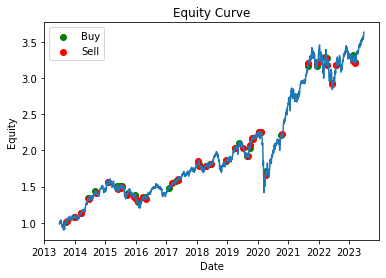

In [19]:
equity_curve = np.cumprod(1 + np.array(returns))
plt.plot(df.index[1:len(equity_curve)+1], equity_curve)

buy_indices = np.where(df.index.isin(buy_dates))[0]
sell_indices = np.where(df.index.isin(sell_dates))[0]

# Adjust the sell indices to match the length of the equity curve
sell_indices = sell_indices[sell_indices < len(equity_curve)]

plt.scatter(df.index[buy_indices], equity_curve[buy_indices], color='green', label='Buy')
plt.scatter(df.index[sell_indices], equity_curve[sell_indices], color='red', label='Sell')

plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.legend()
plt.show()

In [20]:
print('Cumulative Returns:', cumulative_returns)
print('Maximum Drawdown:', max_drawdown)
print('Sharpe Ratio:', sharpe_ratio)

Cumulative Returns: -0.14150949556534717
Maximum Drawdown: -1.458667880491174
Sharpe Ratio: 0.8718232850959001
